## 사용함수 정의

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sqlalchemy import create_engine
from datetime import datetime
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import boto3
import seaborn as sns
from plugins import connector

warnings.filterwarnings('ignore')


    
def extract_data(cur, sql):
    cur.execute(sql)
    columns = [desc[0] for desc in cur.description]
    results = cur.fetchall()
    print(f'{len(results)}행 추출 완료')
    df = pd.DataFrame(results)
    df.columns = columns
    print('데이터프레임 생성 완료')
    return df

In [4]:
conn, cur = connector.redshift_connector()

# sql 수정 후에 사용해도 좋음
# 내가 생각하기에 쓸모 없다고 생각하는 데이터는 뺐음
sql = '''
    SELECT
        P.place_id,
        P.area_congest_id,
        P.area_ppltn_min,
        P.area_ppltn_max,
        W.temp,
        W.sensible_temp,
        W.humidity,
        W.wind_dirct,
        W.wind_spd,
        W.precipitation,
        W.uv_index_lvl,
        W.pm25,
        W.pm10,
        W.air_idx_mvl,
        W.created_date,
        DATE_PART('year', W.created_date) AS year,
        DATE_PART('month', W.created_date) AS month,
        DATE_PART('day', W.created_date) AS day,
        DATE_PART('hour', W.created_date) AS hour,
        DATE_PART('minute', W.created_date) AS minute,
        EXTRACT(DOW FROM W.created_date) AS dow
    FROM
        "raw"."population" AS P
    JOIN
        "raw"."weather" AS W ON P.place_id = W.place_id AND P.created_date = W.created_date;
    '''
    
df = extract_data(cur, sql)
df.info()

Redshift에 연결되었습니다.
39778행 추출 완료
데이터프레임 생성 완료
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39778 entries, 0 to 39777
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   place_id         39778 non-null  int64         
 1   area_congest_id  39778 non-null  int64         
 2   area_ppltn_min   39778 non-null  int64         
 3   area_ppltn_max   39778 non-null  int64         
 4   temp             39778 non-null  float64       
 5   sensible_temp    39778 non-null  float64       
 6   humidity         39778 non-null  int64         
 7   wind_dirct       39778 non-null  object        
 8   wind_spd         39778 non-null  float64       
 9   precipitation    39778 non-null  float64       
 10  uv_index_lvl     39778 non-null  int64         
 11  pm25             39778 non-null  int64         
 12  pm10             39778 non-null  int64         
 13  air_idx_mvl      39778 non-null  int64        

## 예측에 사용할 수 없는 변수 삭제
- 데이터가 한정되어 있어, year, month는 일년동안 데이터를 쌓지 않는 이상 제대로 된 변수로 사용될 수 없을 것 같아 drop 하였습니다.
- area_ppltn_min, area_ppltn_max, sensible_temp, uv_index_lvl, pm25, pm10, air_idx_mvl 컬럼은 예측 시점의 데이터를 가져오는 것이 불가능하기에 제외하였습니다.
- minute 컬럼은 시간대로 예측을 진행하며, 불필요한 변수라고 판단하여 삭제하였습니다.

In [5]:
cannotuse_columns = ['year', 'month', 'area_ppltn_min', 'area_ppltn_max', 'sensible_temp', 'wind_dirct', 'uv_index_lvl', 'pm25', 'pm10', 'air_idx_mvl', 'minute']
df = df.drop(columns = cannotuse_columns)
df

,place_id,area_congest_id,temp,humidity,wind_spd,precipitation,created_date,day,hour,dow
0,4,2,23.1,38,0.9,0.0,2023-06-03 19:30:00,3.0,19.0,6
1,15,1,22.5,51,3.1,0.0,2023-06-03 19:30:00,3.0,19.0,6
2,40,3,23.1,40,4.0,0.0,2023-06-03 19:30:00,3.0,19.0,6
3,42,4,23.9,34,2.5,0.0,2023-06-03 19:30:00,3.0,19.0,6
4,7,1,22.5,51,3.1,0.0,2023-06-03 19:30:00,3.0,19.0,6
...,...,...,...,...,...,...,...,...,...,...
39773,25,1,20.5,79,0.3,0.0,2023-06-22 00:30:00,22.0,0.0,4
39774,31,1,20.4,80,0.1,0.0,2023-06-22 00:30:00,22.0,0.0,4
39775,35,1,20.2,79,1.6,0.0,2023-06-22 00:30:00,22.0,0.0,4
39776,20,1,17.9,96,0.1,0.0,2023-06-22 00:30:00,22.0,0.0,4


# 범주형 변수 분리

In [6]:
categorical_features = ['place_id', 'area_congest_id', 'day', 'hour', 'dow']
df[categorical_features] = df[categorical_features].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39778 entries, 0 to 39777
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   place_id         39778 non-null  category      
 1   area_congest_id  39778 non-null  category      
 2   temp             39778 non-null  float64       
 3   humidity         39778 non-null  int64         
 4   wind_spd         39778 non-null  float64       
 5   precipitation    39778 non-null  float64       
 6   created_date     39778 non-null  datetime64[ns]
 7   day              39778 non-null  category      
 8   hour             39778 non-null  category      
 9   dow              39778 non-null  category      
dtypes: category(5), datetime64[ns](1), float64(3), int64(1)
memory usage: 1.7 MB


# 시각화

### place_id
대부분 고르게 place_id가 있는 것을 알 수 있습니다. 총 48개의 장소입니다.

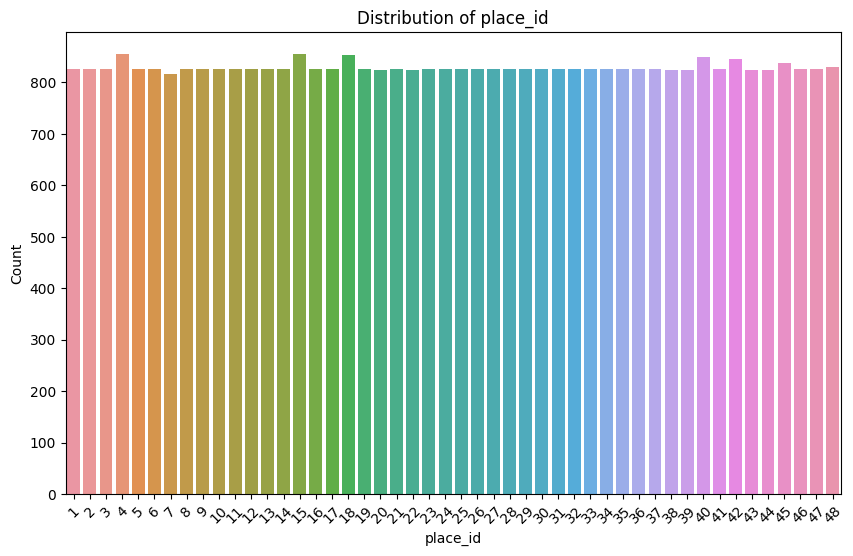

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='place_id')
plt.xlabel('place_id')
plt.ylabel('Count')
plt.title('Distribution of place_id')
plt.xticks(rotation=45)
plt.show()

### area_congest_id
- 여유인 값이 많은 모습입니다. 확실히 붐비는 때가 적습니다.
- 타겟 데이터의 불균형을 해결해야할 것으로 보입니다.
- 오버 샘플링 기법(SMOTE), 혹은 가중치를 주는 방식으로 해결할 예정입니다.

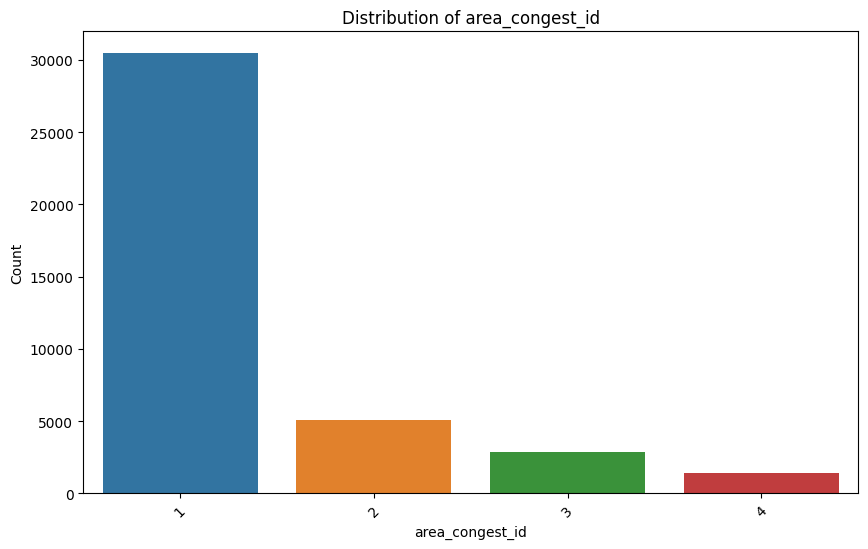

In [13]:
# area_congest_id
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='area_congest_id')
plt.xlabel('area_congest_id')
plt.ylabel('Count')
plt.title('Distribution of area_congest_id')
plt.xticks(rotation=45)
plt.show()

### temp
6월의 데이터만 있어서, 온도가 13도 부근부터 34도 정도까지 있는 것을 볼 수 있습니다.

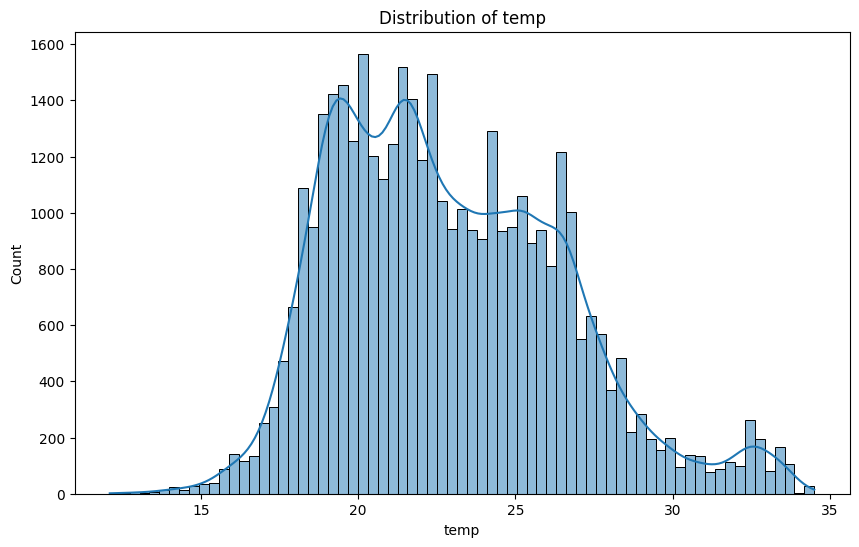

In [11]:
# temp
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='temp', kde=True)
plt.xlabel('temp')
plt.ylabel('Count')
plt.title('Distribution of temp')
plt.show()

### humidity

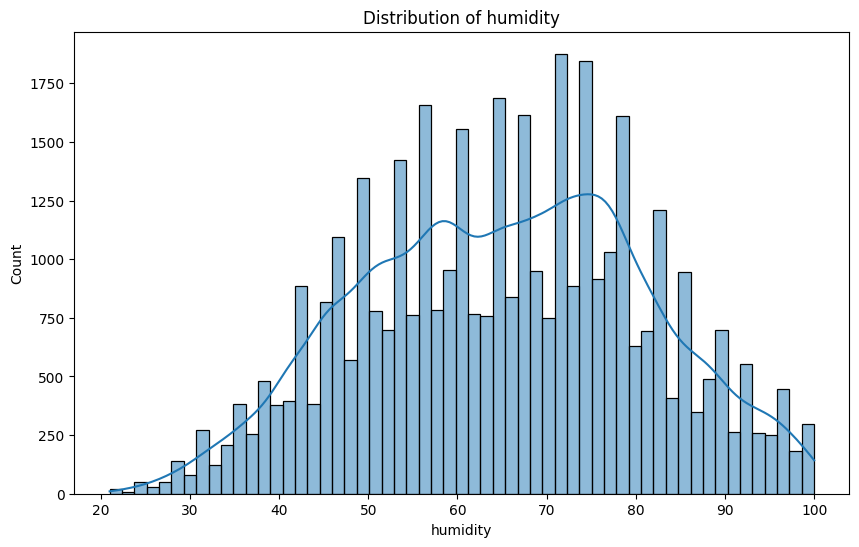

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='humidity', kde=True)
plt.xlabel('humidity')
plt.ylabel('Count')
plt.title('Distribution of humidity')
plt.show()

# windspeed
풍속의 경우에는 데이터가 좌측으로 기울어져있는 것을 알 수 있습니다.

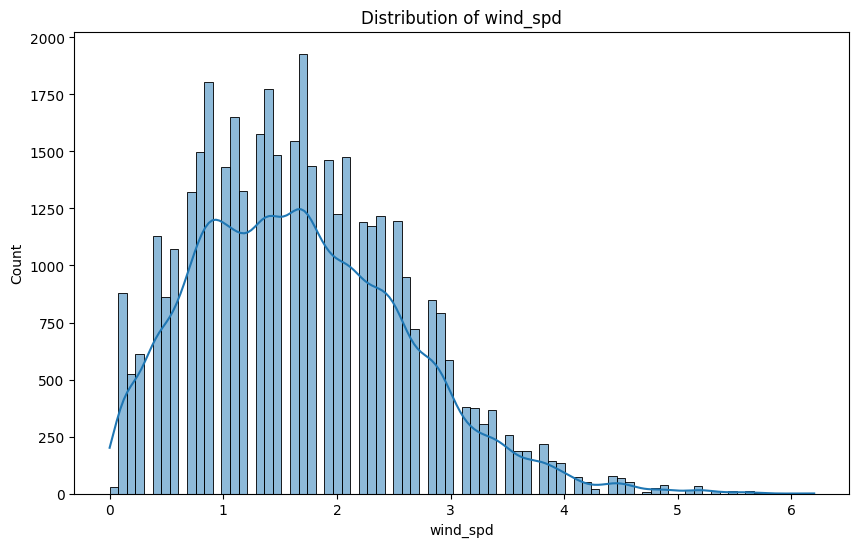

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='wind_spd', kde=True)
plt.xlabel('wind_spd')
plt.ylabel('Count')
plt.title('Distribution of wind_spd')
plt.show()

# precipitation
비가 오지 않는 날이 많아 데이터가 상당히 편중된 것을 알 수 있습니다.

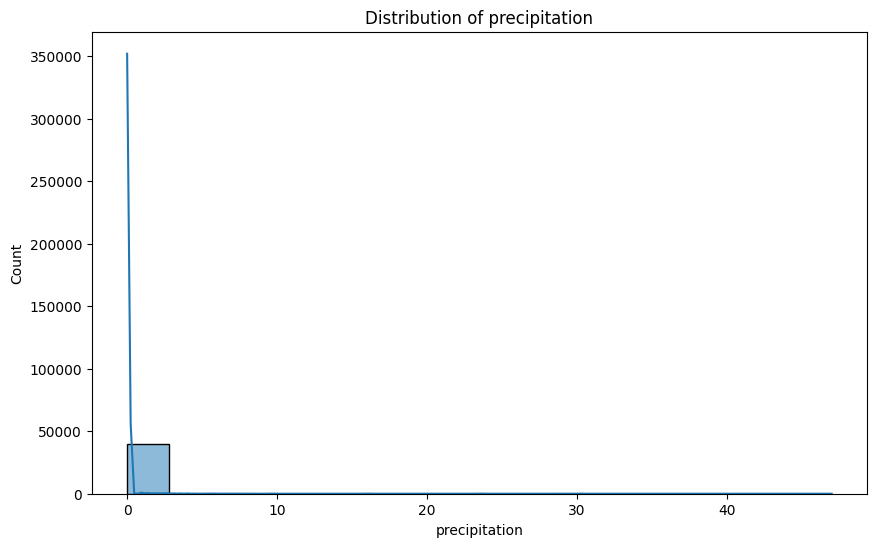

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='precipitation', kde=True)
plt.xlabel('precipitation')
plt.ylabel('Count')
plt.title('Distribution of precipitation')
plt.show()

### created_date
데이터가 계속해서 잘 있다가, 6월 19일 부근부터 몇몇 데이터가 없는 것을 알 수 있습니다.

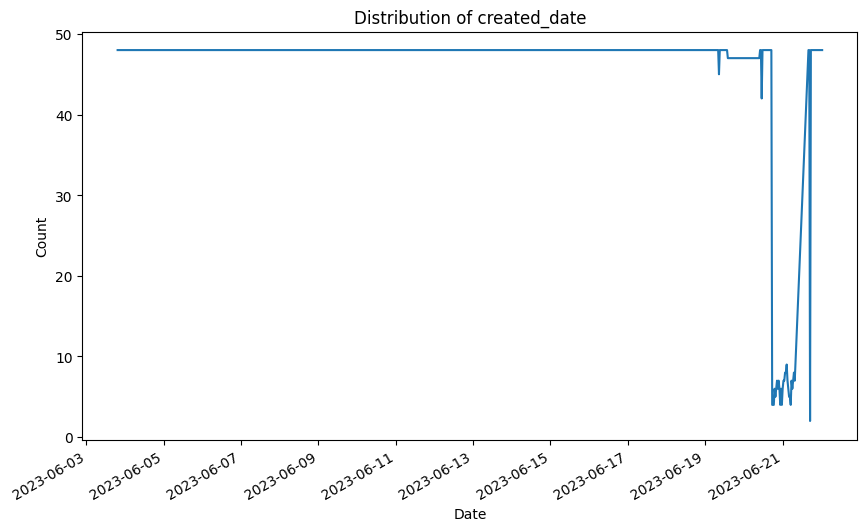

In [16]:
plt.figure(figsize=(10, 6))
df['created_date'].value_counts().sort_index().plot()
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of created_date')
plt.show()

### day

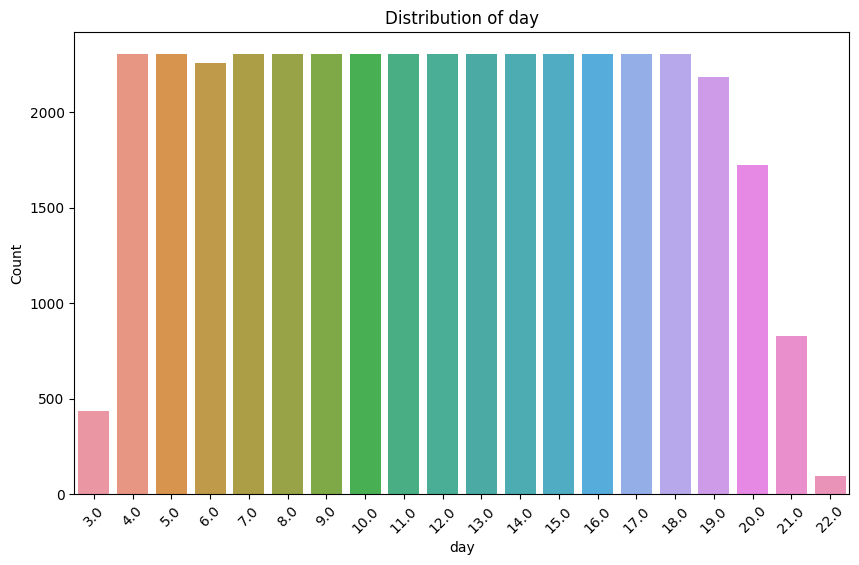

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='day')
plt.xlabel('day')
plt.ylabel('Count')
plt.title('Distribution of day')
plt.xticks(rotation=45)
plt.show()

# hour
0시부터 23시까지 고르게 분포한 것을 볼 수 있습니다.

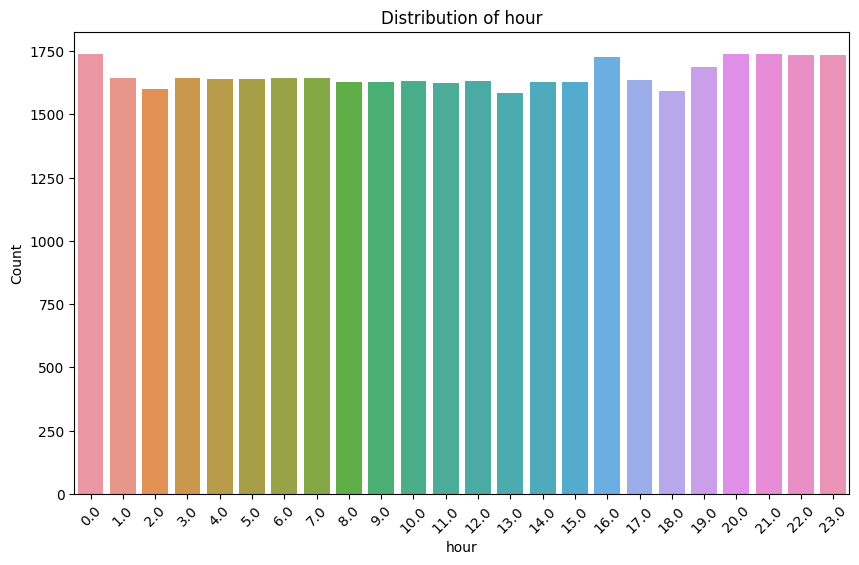

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='hour')
plt.xlabel('hour')
plt.ylabel('Count')
plt.title('Distribution of hour')
plt.xticks(rotation=45)
plt.show()

# dow
현재 데이터에는 일요일이 가장 많습니다.
0 : 일요일 ~ 6: 토요일

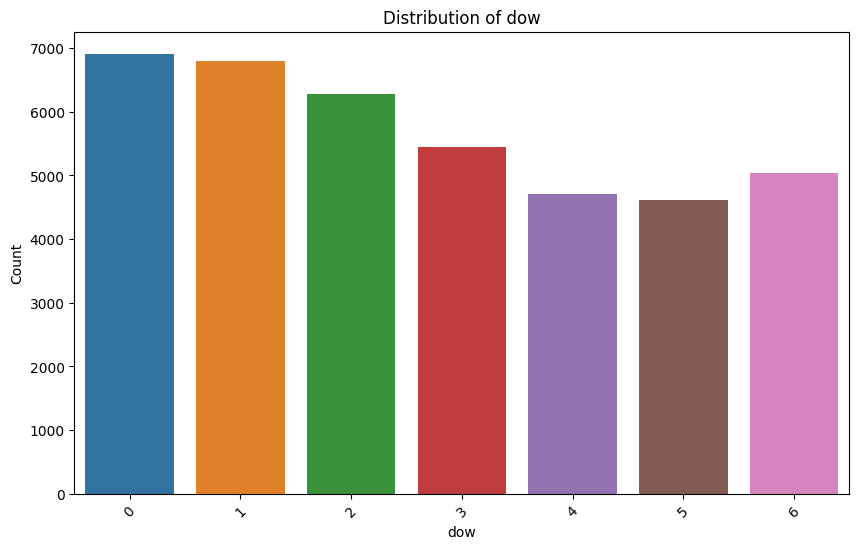

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='dow')
plt.xlabel('dow')
plt.ylabel('Count')
plt.title('Distribution of dow')
plt.xticks(rotation=45)
plt.show()

## 연속형 변수 간 타겟변수의 상관관계 시각화
- temp와 humidity 간의 다중공선성을 의심할만한 상관관계가 발견 되는 것을 알 수 있습니다
- statsmodels을 활용하여 VIF를 확인하였습니다. 해당 VIF는 7.14로 다중공선성이 의심되나 심각한 수준은 아닌 것으로 보입니다.
- 모델링 과정에서 유의하여, 모델링 진행할 예정입니다.

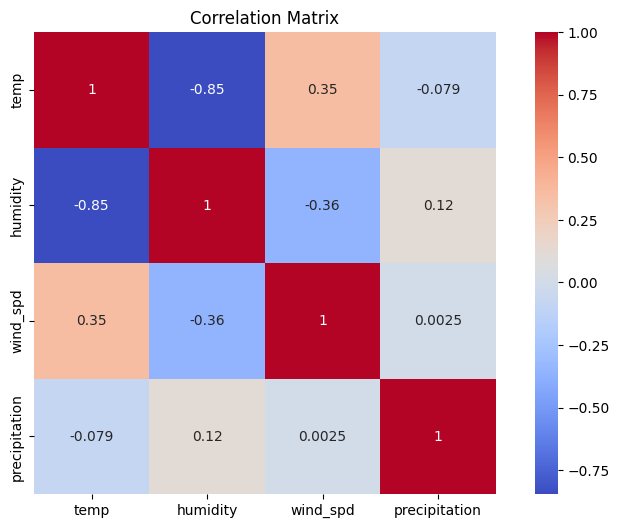

In [26]:
plt.figure(figsize=(10, 6))
corr_matrix = df[['temp', 'humidity', 'wind_spd', 'precipitation']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [37]:
# VIF 계산 함수
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# 다중공선성 평가
variables = ['temp', 'humidity']
X = df[variables]

vif_result = calculate_vif(X)
vif_result

,Variable,VIF
0,temp,7.14558
1,humidity,7.14558


# 타겟변수와 범주형 변수간의 상관관계 시각화

### place_id
특정 지역만 혼잡한 구간이 몰려있는 것을 알 수 있습니다.

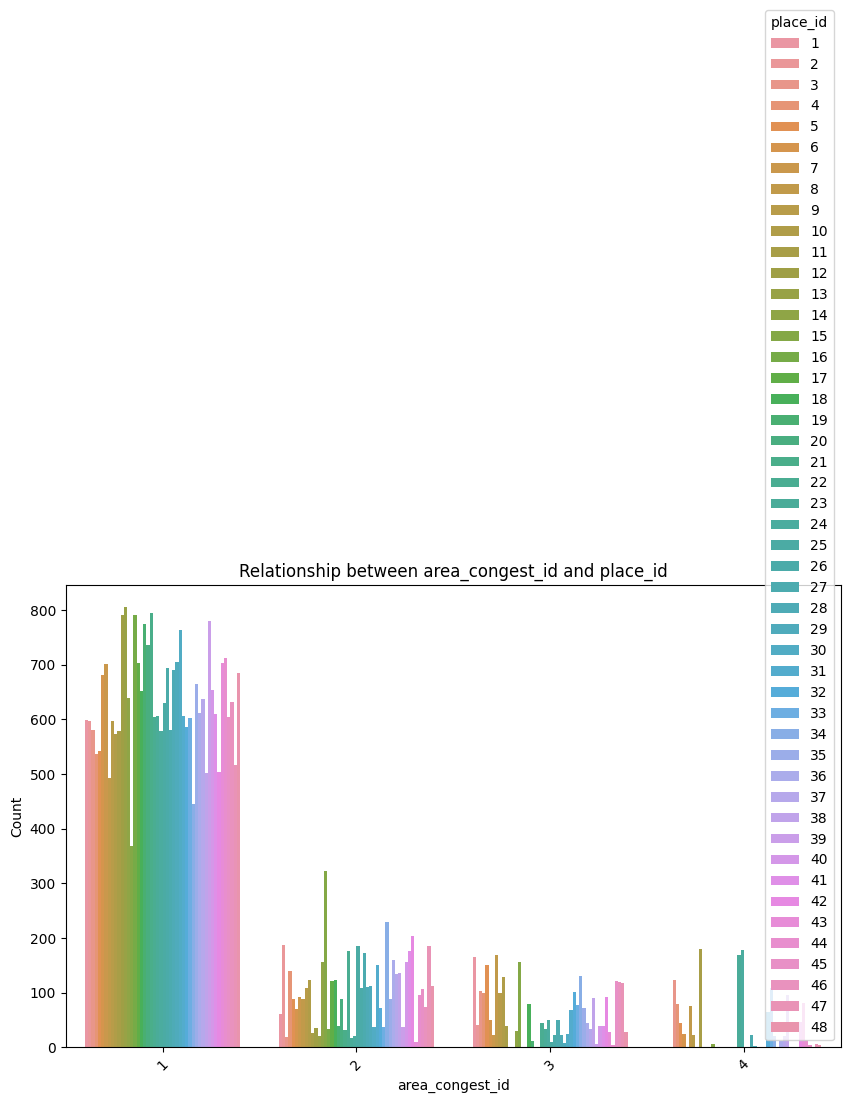

In [30]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='area_congest_id', hue='place_id')
plt.xlabel('area_congest_id')
plt.ylabel('Count')
plt.title('Relationship between area_congest_id and place_id')
plt.xticks(rotation=45)
plt.legend(title='place_id')
plt.show()

# day
딱히 상관관계가 보이지 않습니다.

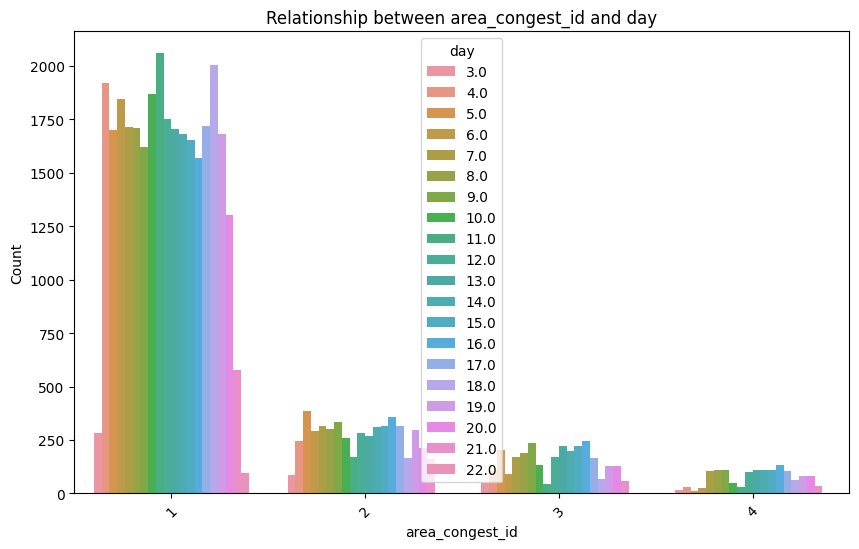

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='area_congest_id', hue='day')
plt.xlabel('area_congest_id')
plt.ylabel('Count')
plt.title('Relationship between area_congest_id and day')
plt.xticks(rotation=45)
plt.legend(title='day')
plt.show()

### hour
- 18시 ~ 19시 사이에 가장 혼잡해지는 구간이 많은 것으로 보입니다.
- 오전부터 서서히 혼잡해지더니, 18~19시에 정점을 찍고, 이후 내려오는 것으로 보입니다.

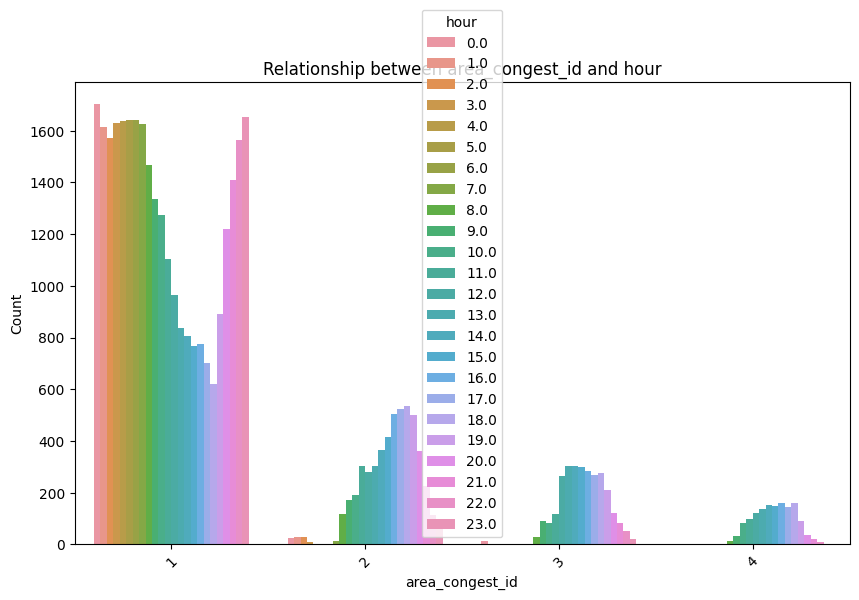

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='area_congest_id', hue='hour')
plt.xlabel('area_congest_id')
plt.ylabel('Count')
plt.title('Relationship between area_congest_id and hour')
plt.xticks(rotation=45)
plt.legend(title='hour')
plt.show()

# dow(요일)
- 평일에 금요일로 갈 수록 혼잡한 구간이 늘어납니다.
- 주말에는 혼잡한 곳이 다소 완화되는 것으로 보입니다.

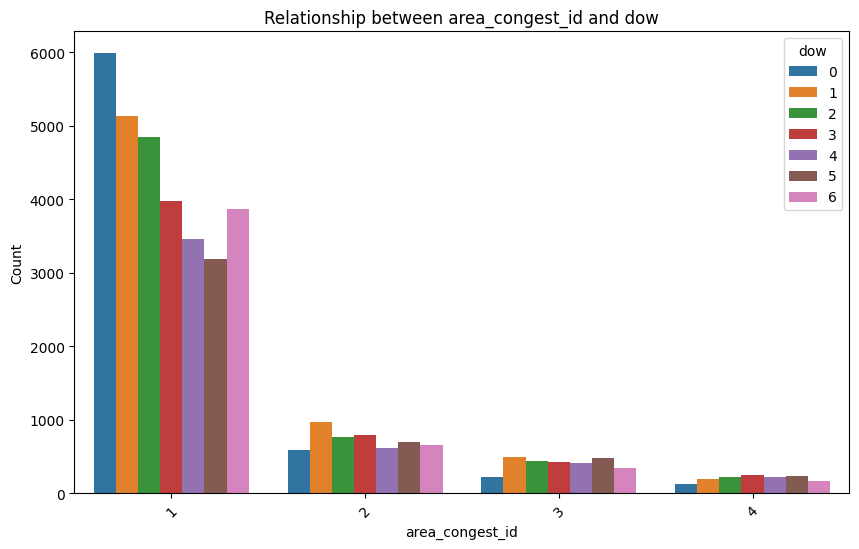

In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='area_congest_id', hue='dow')
plt.xlabel('area_congest_id')
plt.ylabel('Count')
plt.title('Relationship between area_congest_id and dow')
plt.xticks(rotation=45)
plt.legend(title='dow')
plt.show()